# Trabalho #2 - Classificação binária com rede neural deep-learning

Nesse trabalho você vai desenvolver uma rede neural rasa e uma deep-learning, usando a plataforma TensorFlow-Keras, para realizar uma tarefa de classificação binária para reconhecer gatos em imagens e comparar o desempenho das duas redes.

## Identificação

Nome: Wallace de Castro Galvão

## 1 - Bibliotecas ##

Em primeiro lugar, execute a célula abaixo para importar algumas bibliotecas Python que são usadas nesse trabalho. 
- [numpy](www.numpy.org) é a biblioteca básica para computação cinetífica usando Python.
- [h5py](http://www.h5py.org) é uma biblioteca que fornece funções para interagir com banco de dados salvos em arquivos no formato h5.
- [matplotlib](http://matplotlib.org) é uma biblioteca famosa usada para fazer gráficos com Python.
- [PIL](http://www.pythonware.com/products/pil/) e [scipy](https://www.scipy.org/) são usadas para testar a sua RNA com novas imagens no final do trabalho.
- lr_utils é um arquivo com uma função para ler os dados usados nesse trabalho.

O comando da célula abaixo importa o TensorFlow e verifica a versão que está sendo utilizada.

In [1]:
import tensorflow as tf
tf.__version__

2024-08-26 18:49:13.503874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 18:49:14.532864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 18:49:14.811593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 18:49:15.438625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 18:49:15.588357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 18:49:16.603215: I tensorflow/core/platform/cpu_feature_gu

'2.17.0'

Como o TensorFlow é um software aberto não existe muita preocupação do desenvolvedor (no caso o Google) de manter a compatibilidade entre as versões. Assim, se você estiver usando uma versão do TensorFlow incompatível com o seu programa, você pode impor o uso de uma versão mais antiga. 

Por exemplo o código abaixo importa a versão 2 do TensorFlow, mas se ela não estiver instalada importa a versão instalada.

```
 try:
     import tensorflow.compat.v2 as tf
 except Exception:
     import tensorflow as tf    
 print(tf.__version__)
```

Outro exemplo, se a versão instalada do TensorFlow for a 2 e o seu programa foi feito para a versão 1, então pode habilitar a versão 2 com o comportamento da versão 1. O código abaixo mostra como fazer isso.

```
 import tensorflow as tf
 print(tf.__version__)
 tf.enable_v1_behavior()
``` 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Visão geral do problema ##

**Definição do problema**: 

Nesse trabalho é fornecido um conjunto de dados que contém:

    - um conjunto de imagens de treinamento classificadas como tendo gato (y=1) ou não tendo gato (y=0);
    - um conjunto de imagens de teste classificadas como tendo gato (y=1) ou não tendo gato (y=0);
    - a dimensão de cada imagem é (num_px, num_px, 3), onde 3 é o número de canais de cor (RGB);
    - cada imagem é composta por três matrizes de dimensão: número de linhas = num_px e número de colunas = num_px;
    - número de imagens do conjunto de treinamento: m_train;
    - número de imagens do conjunto de teste: m_test.

A partir desses conjuntos de dados, a sua tarefa é desenvolver um sistema baseado em uma rede neural, para processar imagens e classificar corretamente se ela mostra ou não um gato. Para isso, você vai desenvolver algumas redes neurais usando a ferramenta Keras e comparar o desempenho delas. 

O uso da ferramenta Keras para desenvolver redes neurais facilita muito o trabalho, pois não exige desenvolver codigos específicos para implementar cada camada da rede, a função de custo, a métrica e principalmente o gradiente descendente.

## 3 - Conjunto de dados de treinamento e teste

O conjunto de dados utilizado pode ser obtido em: https://www.kaggle.com/mriganksingh/cat-images-dataset. Para carregar esse conjunto de dados execute o código a seguir.

O termo _orig é adicionado no final dos tensores com os dados de treinamento e teste originais porque vamos processar esses dados.

In [3]:
# Conjunto de dados de treinamento
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
train_set_y = np.array(train_dataset["train_set_y"][:]) 

# Conjunto de dados de teste
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y = np.array(test_dataset["test_set_y"][:]) 

# Acerta dimensões das saídas
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
classes = np.array(test_dataset["list_classes"][:]) # the list of classes

(64, 64, 3)
y = [1], it's a 'cat' picture.


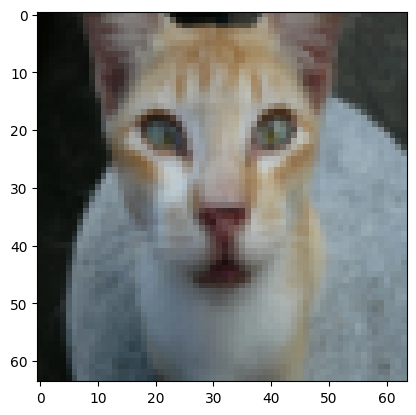

In [4]:
# Examplo de uma imagem
index = 11
print(train_set_x_orig[index].shape)
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

No código acima index é o número sequencial da imagem. Tente trocar a imagem, mudando o index, usando valores entre 0 e 208, para visualizar outros exemplos.

### 3.1 - Determinação do formato e dimensões dos dados

### Exercício #1:

É importante conhecer as dimensões dos dados que estamos trabalhando para evitar problemas. Assim, obtenha os valores dos seguintes parâmetros: 
    - m_train = número de exemplos de treinamento;
    - m_test = número de exemplos de teste;
    - num_px = altura e largura das imagens (as imagens são quadradas).
    
Lembre que `train_set_x_orig` é um tensor numpy de dimensão (m_train, num_px, num_px, 3). Por exemplo, você pode obter  `m_train` escrevendo `train_set_x_orig.shape[0]`.

In [5]:
# PARA VOCÊ FAZER:

### COMECE AQUIE ### (≈ 3 linhas)
m_train = train_set_x_orig.shape[0]  # Número de exemplos de treinamento
m_test = test_set_x_orig.shape[0]    # Número de exemplos de teste
num_px = train_set_x_orig.shape[1]   # Altura e largura das imagens (as imagens são quadradas)
### TERMINE AQUI ###

print ("Número de exemplos de treinamento: m_train = " + str(m_train))
print ("Número de exemplos de teste: m_test = " + str(m_test))
print ("Altura/largura de cada imagem: num_px = " + str(num_px))
print ("Dimensão de cada imagem: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("Dimensão - train_set_x: " + str(train_set_x_orig.shape))
print ("Dimensão - train_set_y: " + str(train_set_y.shape))
print ("Dimensão - test_set_x: " + str(test_set_x_orig.shape))
print ("Dimensão - test_set_y: " + str(test_set_y.shape))

Número de exemplos de treinamento: m_train = 209
Número de exemplos de teste: m_test = 50
Altura/largura de cada imagem: num_px = 64
Dimensão de cada imagem: (64, 64, 3)
Dimensão - train_set_x: (209, 64, 64, 3)
Dimensão - train_set_y: (1, 209)
Dimensão - test_set_x: (50, 64, 64, 3)
Dimensão - test_set_y: (1, 50)


**Saída esperada para m_train, m_test e num_px**: 

    Número de exemplos de treinamento: m_train = 209
    Número de exemplos de teste: m_test = 50
    Altura/largura de cada imagem: num_px = 64
    Dimensão de cada imagem: (64, 64, 3)
    Dimensão - train_set_x: (209, 64, 64, 3)
    Dimensão - train_set_y: (1, 209)
    Dimensão - test_set_x: (50, 64, 64, 3)
    >Dimensão - test_set_y: (1, 50)

Observe que o primeiro eixo dos tensores com as imagens dos conjuntos de teste e de treinamento representa os exemplos, da forma como é esperado para os dados no Keras.

### 3.2 - Processamento dos dados

Os dados dos exemplos de treinamento e de teste devem ser processados de forma a serem colocados em tensores com as dimensões adequadas e normalizados corretamente. Nos exercícios que seguem você irá realizar o processamento dos dados de forma a poderem ser usados na sua RNA implementada com o Keras.

### Redimensionamento dos dados

Os dados de entrada de uma camada de neurônios densa é um vetor, assim, devemos redimensionar as imagens, que tem dimensão (num_px, num_px, 3), para transformá-las em um vetor linha de dimensão (1, num_px∗num_px∗3). Após esse redimensionamento o conjunto de dados é um tensor numpy onde cada linha representa uma imagem "esticada". O tensor com as entradas dos dados de treinamento terá m_train linhas e o de teste m_test linhas.

Por exemplo, para redimensionar uma matriz de dimensão (a,b,c,d) para uma matriz de dimensão (a, b∗c∗d) pode-se usar o seguinte código Python: 

    X_flatten = X.reshape((a, b∗c∗d))

A dimensão dos dados de saída também deve ser alterada porque, como visto, o Keras espara que os exemplos representam o primeiro eixo do tensor e nos dados de saída os exemplos representam o segundo eixo. Assim, os vetores com os dados de saída, tanto de treinamento como de teste, devem ser transpostos.

### Exercício #2:

Implemente o redimensionamento dos dados de entrada na célula a seguir.

In [6]:
# PARA VOCÊ FAZER: redimensionamento das imagens dos exemplos de treinamento e teste

### COMECE AQUI ### (≈ 2 linhas)
# Redimensionamento dos dados de entrada
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)

# Redimensionamento dos dados de saída (transposição)
train_set_y = train_set_y.T
test_set_y = test_set_y.T
### TERMINE AQUI ###

print ("Dimensão - train_set_x_flatten: " + str(train_set_x_flatten.shape))
print ("Dimensão - train_set_y: " + str(train_set_y.shape))
print ("Dimensão - test_set_x_flatten: " + str(test_set_x_flatten.shape))
print ("Dimensão - test_set_y: " + str(test_set_y.shape))
print ("Verificação de valores após redimensionamento: " + str(train_set_x_flatten[0,0:5]))

Dimensão - train_set_x_flatten: (209, 12288)
Dimensão - train_set_y: (209, 1)
Dimensão - test_set_x_flatten: (50, 12288)
Dimensão - test_set_y: (50, 1)
Verificação de valores após redimensionamento: [17 31 56 22 33]


**Saída esperada**: 

    Dimensão - train_set_x_flatten: (209, 12288)
    Dimensão - train_set_y: (209, 1)
    Dimensão - test_set_x_flatten: (50, 12288)
    Dimensão - test_set_y: (50, 1)
    Verificação de valores após redimensionamento: [17 31 56 22 33]

### Normalização dos dados

Nas imagens coloridas as cores vermelho, verde e azul (RGB) são especificadas para cada pixel da imagem, de forma que cada pixel consite de um vetor de tres números que variam no intervalo de 0 a 255.

Uma etapa do processamento dos dados é normalizar esses dados de forma a ter dados com média zero e desvio padrão um. No caso de imagens o processo de normalização dos dados é mais simples e consiste simplesmente em dividir todos os valores da imagem por 255, que é o valor máximo de um pixel.

### Exercício #3:

Implemente a normalização dos dados de forma a ter todas os elementos dos dados de entrada entre 0 e 1.

In [7]:
# PARA VOCÊ FAZER: redimensionamento das imagens dos exemplos de treinamento e teste

### COMECE AQUI ### (≈ 2 linhas)
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.
### TERMINE AQUI ###

print ("Máximo valor de train_set_x: " + str(np.max(train_set_x)))
print ("Máximo valor de train_set_x: " + str(np.max(test_set_x)))

Máximo valor de train_set_x: 1.0
Máximo valor de train_set_x: 1.0


**Saída esperada**: 

    Máximo valor de train_set_x: 1.0
    Máximo valor de train_set_x: 1.0


<font color='blue'>
    
**O que é importante lembrar:**

As etapas principais do processamento de dados são as seguintes:
- Verificar a dimensão e formato dos dados do problema. Nesse caso são: m_train, m_test, num_px, ...
- Redimensionar os conjuntos de dados. Nesse caso para cada exemplo a entrada é um vetor linha de dimensão (1, num_px \* num_px \* 3)
- Normalizar os dados

## 4 - Desenvolvimento e teste da rede neural rasa

Nesse trabalho vamos testar diferentes redes neurais, variando numero de camadas, numero de neurônios nas camadas e tipo de função de ativação para obtermos uma solução que apresente resultados satisfatórios.

Conforme vimos em aula, o desenvolvimento de uma RNA com o Keras é feito segundo as seguintes etapas:

1. Definição dos dados de treinamento e de teste;
2. Configuração da RNA;
3. Compilação da RNA, que também inclui a configuração do processo de treinamento pela escolha da função de custo, do otimizador e da métrica para avaliar o desempenho;
4. Treinamento da RNA;
5. Teste e avaliação do desempenho da RNA.

Observe que a etapa de definição e preparação dos dados já foi realizada.

### 4.1 - Configuração da rede neural ## 

Vamos configurar, treinar e testar uma primeira rede neural simples de uma camada intermediária usando o Keras.

Para essa rede de uma camada, o parâmetro mais importante é o número de neurônios da camada intermediária. Esse número deve ser compatível com o problema que queremos resolver e também com o número de exemplos que temos disponíveis para treinar a rede.

Em linhas gerais cada imagem é representada por 12.288 números e temos 209 imagens de treinamento. Assim, no conjunto de dados de treinamento temos cerca de 2,6 milhões de valores. Existem um princípio em aprendizado supervisionado que diz que o número de parâmetros do sistema deve ser menor do que o número de valores presente no conjunto de dados utilizado para o treinamento. Assim, a sua rede neural deve ter um número de parâmetros menor do que 2,6 milhões. Se a rede possuir mais parâmetros do que o número de valores presentes no conjunto de dados, ela simplesmente memoriza os dados de treinamento e não funciona direito para nenhum outro caso.

**Qualquer dúvida que você possa ter de como fazer esse trabalho usando o Keras, consulte os slides e o notebook da aula no Moodle**

### Exercício #4:

Usando o Keras configure uma rede neural com as seguintes caracteríticas:

- uma única camada intermediária com 64 neurônios e função de ativação sigmóide;
- como queremos resolver um problema de classificação binária a camada de saída deve possuir um único neurônio e ter função de ativação sigmóide.


In [8]:
# PARA VOCÊ FAZER: configuração de uma RNA rasa

# Importar do Keras classes de modelos e camadas 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

np.random.seed(1) # inicializa gerador de números aleatórios

# Configuração da rede
rna = Sequential([
    Dense(64, activation='sigmoid', input_shape=(train_set_x.shape[1],)),  # Camada intermediária com 64 neurônios e ativação sigmóide
    Dense(1, activation='sigmoid')  # Camada de saída com 1 neurônio e ativação sigmóide
])
### TERMINE AQUI ###

# Visualização da rede
rna.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,561 (3.00 MB)

 Trainable params: 786,561 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense (Dense)                (None, 64)                786496    
    _________________________________________________________________
    dense_1 (Dense)              (None, 1)                 65        
    =================================================================
    Total params: 786,561
    Trainable params: 786,561
    Non-trainable params: 0
    _________________________________________________________________

### 4.2 - Compilação e treinamento da rede neural

A segunda e terceira etapas de desenvolvimento da rede no Keras é a sua compilação e treinamento. 

### Exercício #5:

Compile e treine a sua rede neural usando as seguintes opções:

- Método de otimização: gradiente descendente;
- Função de custo: entropia cruzada;
- Métrica: exatidão;
- No treinamento, utilize no método fit o parâmetro batch_size=209, que é o número de exemplos de treinamento;
- Número de épocas: 10.

Nesse momento estamos treinando a rede somente para verificar se ela é adequada para resolver o problema e se está configurada de forma correta, por isso usamos poucas épocas de treinamento.

Note que para o Keras, certos parâmetros podem ser definidos de formas distintas. Por exemplo, a métrica "Mean Absolute Error" pode ser definida como keras.metrics.MeanAbsoluteError() ou simplesmente pelo string 'mae'.

In [9]:
# PARA VOCÊ FAZER: configuração do otimizador e treinamento da RNA rasa

# Importar do Keras classe de otimizadores
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Compilação da rede 
### COMECE AQUI ### (≈ 1 ou 2 linhas)
rna.compile(optimizer='sgd',  # Gradiente Descendente
            loss='binary_crossentropy',  # Função de custo: entropia cruzada
            metrics=['accuracy'])  # Métrica: exatidão
### TERMINE AQUI ###

# Teste de treinamento da rede
### COMECE AQUI ### (≈ 1 linha)
rna.fit(train_set_x, train_set_y, epochs=10, batch_size=209)
### TERMINE AQUI ###

Epoch 1/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.4545 - loss: 0.7064
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6507 - loss: 0.6556
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6555 - loss: 0.6460
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6555 - loss: 0.6433
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6555 - loss: 0.6420
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6555 - loss: 0.6410
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6555 - loss: 0.6401
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6555 - loss: 0.6391
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6555 - loss: 0.6382
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6555 - loss: 0.6373


**Saída esperada:**

    Epoch 1/10
    209/209 [==============================] - 0s 1ms/sample - loss: 0.7257 - acc: 0.3876
    Epoch 2/10
    209/209 [==============================] - 0s 272us/sample - loss: 0.6633 - acc: 0.6555
    Epoch 3/10
    209/209 [==============================] - 0s 162us/sample - loss: 0.6539 - acc: 0.6459
    Epoch 4/10
    209/209 [==============================] - 0s 153us/sample - loss: 0.6515 - acc: 0.6507
    Epoch 5/10
    209/209 [==============================] - 0s 153us/sample - loss: 0.6502 - acc: 0.6507
    Epoch 6/10
    209/209 [==============================] - 0s 143us/sample - loss: 0.6491 - acc: 0.6507
    Epoch 7/10
    209/209 [==============================] - 0s 153us/sample - loss: 0.6481 - acc: 0.6507
    Epoch 8/10
    209/209 [==============================] - 0s 166us/sample - loss: 0.6471 - acc: 0.6507
    Epoch 9/10
    209/209 [==============================] - 0s 157us/sample - loss: 0.6461 - acc: 0.6507
    Epoch 10/10
    209/209 [==============================] - 0s 167us/sample - loss: 0.6451 - acc: 0.6507
    
Se o seu resultado é esse ou parecido com esse, você pode conluir que a rede está correta e é capaz de aprender os dados de treinamento. Assim, agora você está pronto para treinar a rede de verdade.

Atenção: É normal que os valores sejam ligeiramente diferentes nesta etapa. Mesmo com seeds aleatórios fixos, algumas etapas do treinamento podem não ser completamente determinísticas.

### Exercício #6:

Retreine a sua rede usando 1000 épocas. 

Use a opção de **não imprimir** os resultados parciais do treinamento para não gerar tantos dados. No Keras podemos escolher como monitoramos o progresso do treinamento com o parâmetro verbose do método fit, que nos dá as seguintes opções:

- verbose: inteiro = 0, 1, or 2. 
- verbose = 0: silencioso;
- verbose = 1; barra de progresso (padrão);
- verbose = 2; uma linha por época.

Guarde os resultados do treinamento para poder fazer um gráfico do processo de treinamento. Se tiver dúvidas, veja no notebook desenvolvido em aula como fazer isso.

Não se esqueça de usar no método fit o parâmetro batch_size=209.

Esse treinamento pode levar alguns minutos. No Google Colab levou cerca de 30 segundossem uso de GPU, mas pode variar dependendo de detalhes da implementação e da carga nos servidores do Colab

In [16]:
# PARA VOCÊ FAZER: treinamento da RNA por 1000 épocas
# REFAZENDO COM 5000 ÉPOCAS 

### COMECE AQUI ### (≈ 1 linha)
history = rna.fit(train_set_x, train_set_y, epochs=5000, batch_size=209, verbose=0)
### TERMINE AQUI ###

In [17]:
# Vamos verificar quais variáveis foram salvas no processo de treinamento
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss'])

### 4.3 - Visualização do resultado do treinamento

Para sabermos como o treinamento foi realizado precisamos visualizar a função de custo e a métrica ao longo do processo de treinamento.

### Exercício #7: 

Implemente na célula abaixo a visualização dos resultados do treinamento. Observe que os valores da função de custo e da métrico estão no dicionário history com nomes `'loss'` e `'acc'`. Mas estes nomes podem variar, de acordo com a forma que os parâmetros foram definidos. Verifique a variável history_dict history_dict.keys() para conferir os nomes corretos.

Consulte as notas de aula para relembrar como fazer os gráficos da função de custo e da métrica em função do número de épocas.

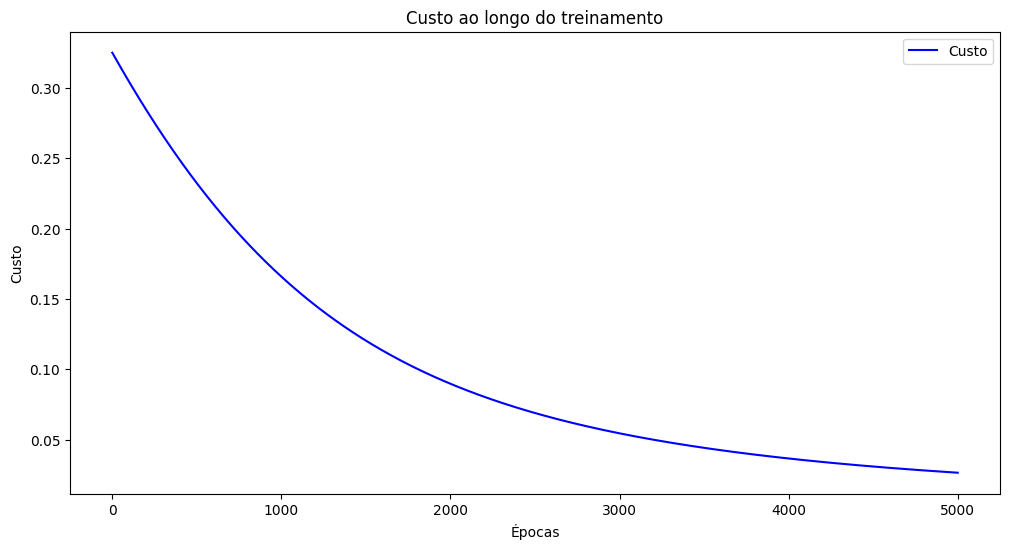

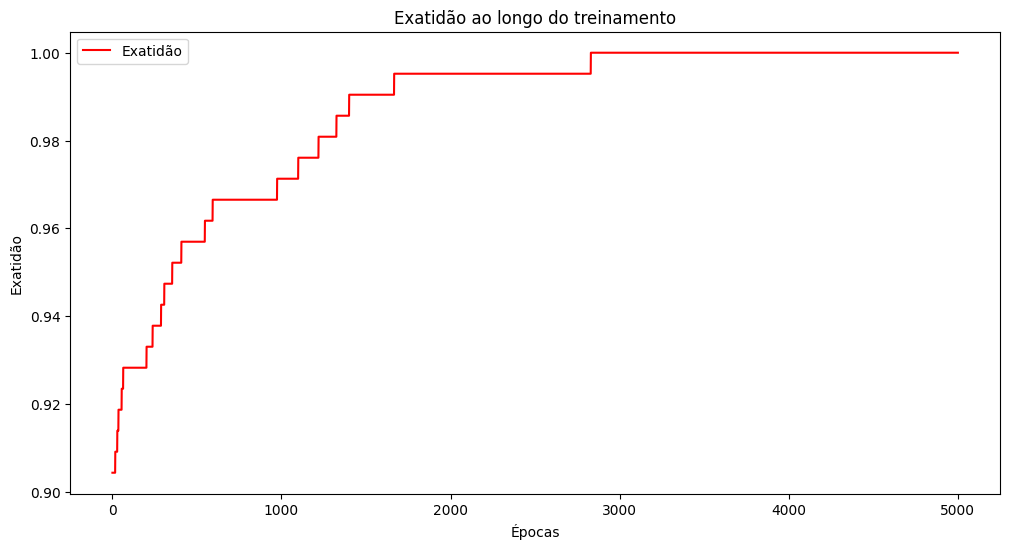

In [18]:
# PARA VOCÊ FAZER: visualização do resultado do treinamento

# Salva custo e exatidão em vetores
### COMECE AQUI ###

history_dict = history.history
custo = history_dict['loss']
exatidao = history_dict['accuracy']  # Verifique se é 'accuracy', pode variar dependendo da versão do Keras

### TERMINE AQUI ###

# Cria vetor de épocas
### COMECE AQUI ###

epocas = range(1, len(custo) + 1)

### TERMINE AQUI ###

# Gráfico do custo em função das épocas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(epocas, custo, 'b-', label='Custo')
plt.title('Custo ao longo do treinamento')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

### TERMINE AQUI ###

# Gráfico da exatidão em função das épocas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(epocas, exatidao, 'r-', label='Exatidão')
plt.title('Exatidão ao longo do treinamento')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

### TERMINE AQUI ###

**Saída esperada:**

O comportamento esperado para a função de custo durante o treinamento é ela decrescer monotomicamente do início até o final. Para a exatidão, o comportamento esperado é ela aumentar durante o treinamento, apresentando algumas oscilações e alcançando um valor alto no final. 

Se você obteve esses resultados, então, a sua rede foi treinada de forma satisfatória e pode-se concluir que ela tem uma capacidade alta para se ajustar aos dados de treinamento.

### 4.4 - Avaliação do desempenho da rede neural ###

Após treinar a RNA é importante avaliar o seu desempenho com dados que não foram  utilizados no treinamento. Para isso usamos o dados de teste, que estão nos tensores test_set_x e test_set_y. 

### Exercício #8:

Avalie a sua rede neural calculando os valores da função de custo e da exatidão para os dados de teste usando o método evaluate. Calcule esses valores também para os dados de treinamento para poder fazer comparação.

In [19]:
# PARA VOCÊ FAZER: calculo do custo e exatidão para os dados de teste

# Usando método evaluate calcule o custo e a exatidão para os dados de treinamento e depois apresente os resultados
### COMECE AQUI ###

custo_e_metricas_train = rna.evaluate(train_set_x, train_set_y, verbose=0)

### TERMINE AQUI ###
print(f"Custo e exatidão nos dados de treinamento: {custo_e_metricas_train}")

# Usando método evaluate calcule o custo e a exatidão para os dados de teste e depois apresente os resultados
### COMECE AQUI ###

custo_e_metricas_test = rna.evaluate(test_set_x, test_set_y, verbose=0)

### TERMINE AQUI ###
print(f"Custo e exatidão nos dados de teste: {custo_e_metricas_test}")

Custo e exatidão nos dados de treinamento: [0.026594551280140877, 1.0]
Custo e exatidão nos dados de teste: [1.1589223146438599, 0.699999988079071]


**Resultados esperados:**

    209/209 [==============================] - 0s 656us/sample - loss: 0.3270 - acc: 0.9091
    [0.3269858589868226, 0.90909094]
    50/50 [==============================] - 0s 260us/sample - loss: 0.5960 - acc: 0.7000
    [0.5959848165512085, 0.7]

**Comentários:**

- A exatidação obtida com os dados de treinamento é cerca de 90%, isso significa que a sua rede é satisfatória para resolver esse problema. 

- A exatidão obtida com os dados de teste é de cerca de 68%. Esse resultado de fato não é muito bom para essa tarefa simples de classificação. 

Analisando esses dados surge uma dúvida. Porque a rede não foi capaz de apresentar um bom desempenho nos dados de teste, se os resultados foram bons nos dados de treinamento?

### Exercício #9:

Para avaliar melhor o desepenho da sua rede calcule as saídas previstas dos exemplos do conjunto de teste usando o método predict e a função numpy round faça um gráfico com as classes reais e previstas dos dados do conjunto de teste. Se não souber como fazer consulte as notas de aula e o notebook que desenvolvemos.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


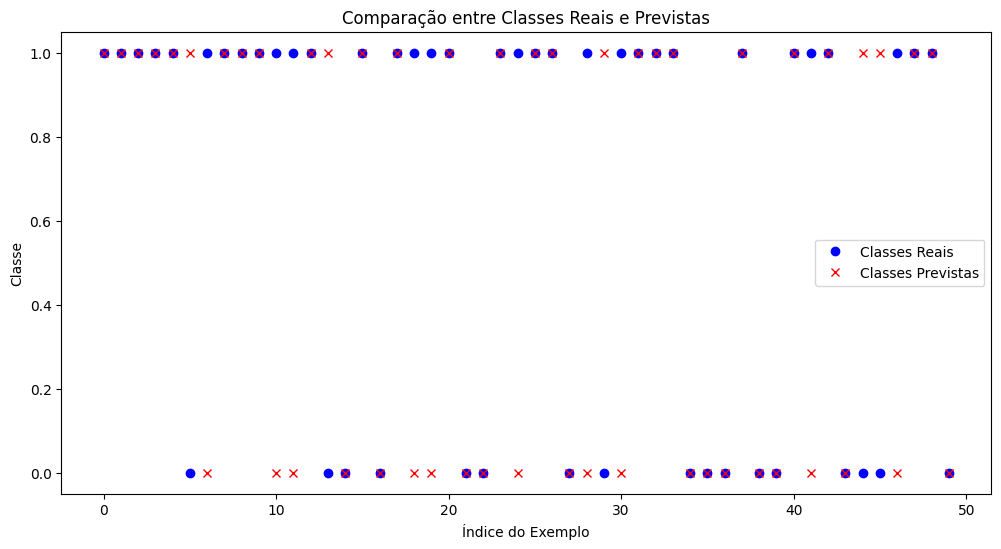

In [20]:
# PARA VOCÊ FAZER: calculo das classes previstas dos dados de teste

# Usando método predict calcule as classes previstas
### COMECE AQUI ###

yy_prev = rna.predict(test_set_x)
yy_prev = np.round(yy_prev).astype(int)  # Transforma saída prevista em números inteiros

### TERMINE AQUI ###

# Gráfico das classes reais e previstas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(test_set_y, 'bo', label='Classes Reais')  # 'bo' para pontos azuis (blue dots)
plt.plot(yy_prev, 'rx', label='Classes Previstas')  # 'rx' para cruzes vermelhas (red crosses)
plt.title('Comparação entre Classes Reais e Previstas')
plt.xlabel('Índice do Exemplo')
plt.ylabel('Classe')
plt.legend()
plt.show()

### TERMINE AQUI ###

**Saída esperada:**

Veja a imagem classes_previstas_test.png fornecida com o material do trabalho


**Comentários:**

- Uma previsão errada de classe pode ser dectada pelos círculos vermelhos, pois quando a classe prevista é igual à classe real o círculo azul é colocado em cima do vermelho tapando-o.

- Provavelmente no grafico devem aparecer mais círculos azuis do que vermelhos indicando que existem mais acertos do que erros na previsão das classes.

Use o código a seguir, mudando a variável 'index', para você visualizar as imagens e a classe prevista dos exemplos de teste.

y = [1], imagem é prevista como sendo uma 'cat


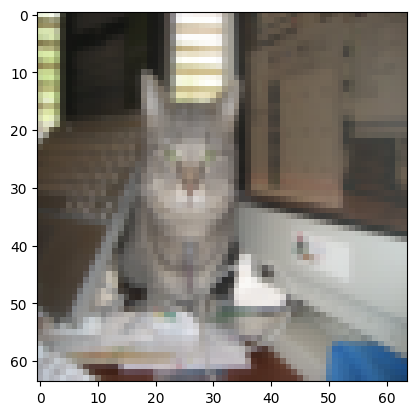

In [33]:
# Exemplo de classificação de uma imagem.
index = 7
plt.imshow(test_set_x[index,:].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[index]) + ", imagem é prevista como sendo uma '" + classes[np.squeeze(yy_prev[index])].decode("utf-8"))

**Interpretação dos resultados:**

O custo decrescendo durante o treinamento mostra que os parâmetros estão sendo ajustados de forma a que a rede está aprendendo os dados de treinamento. Como o custo obtido não é muito baixo, então, provavelmente é possível treinar ainda mais a rede para obter melhores resultados nos dados de treinamento. 

Tente refazer as etapas 4.2, 4.3 e 4.4, aumentando o número de épocas para algo em torno de 5000, para retreinar a rede. Você verá que o custo de treinamento diminui até praticamente zero e a exatidão aumenta para quase 100%. 

**Importante:** só tente treinar com mais épocas após entregar o seu trabalho, pois os resultados esperados são para o treinamento com 1000 épocas.

Contudo, nem sempre é bom treinar a rede até se obter custo perto de zero e exatidão 100% para os dados de treinamento. Em geral quando isso acontece o custo e a exatidão para os dados de teste pioraram. Nesse caso, pode ocorrer que a rede está memorizando os dados de treinamento e não generalizando a solução do problema. Veremos daqui algumas aulas como resolver esse problema. Mas podemos verificar esse fato retreinando a rede para um número maior de épocas. 

## 5 - Desenvolvimento e teste da rede neural deep-learning ## 

Nessa etapa do trabalho você vai configurar, treinar e testar uma rede neural deep learning.

### Exercício #10:

Usando o Keras configure e crie uma rede neural com as seguintes caracteríticas:

- três camadas intermediárias com função de ativação tipo ReLu;
- número de neurônios das camadas intermediárias: 64, 32, 16;
- camada de saída deve possuir um único neurônio e ter função de ativação sigmóide.

Essa rede deve ser criada dentro de uma função (build_model) e os argumentos dessa função são: a dimensão dos dados de entrada e os números de neurônios das diversas camadas.

In [22]:
# PARA VOCÊ FAZER: configuração da rede deep-learning

# Importar do Keras modelos e camadas
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(data_shape, n1, n2, n3, n4):
    """
    Essa função configura uma rede neural deep-learning
    
    Argumentos:
    data_shape = tuple com dimensões dos dados de entrada da rede
    n1 = número de neurônios da primeira camada
    n2 = número de neurônios da segunda camada
    n3 = número de neurônios da terceira camada
    n4 = número de neurônios da camada de saída
        
    Retorna: modelo da rede neural
    """
    
    np.random.seed(3)
    
    model = models.Sequential()
    
    # Adicionando as camadas ao modelo de RNA
    #### COMECE AQUI ###
    model.add(layers.Dense(n1, activation='relu', input_shape=data_shape))  # Primeira camada intermediária
    model.add(layers.Dense(n2, activation='relu'))  # Segunda camada intermediária
    model.add(layers.Dense(n3, activation='relu'))  # Terceira camada intermediária
    model.add(layers.Dense(n4, activation='sigmoid'))  # Camada de saída
    ### TERMINE AQUI ###
    
    return model

# Redefine semente para geração de números aleatórios
np.random.seed(3)

# Dimensão dos dados de entrada
data_shape = (12288,)  # Corresponde ao número de pixels em uma imagem achatada (num_px * num_px * 3)

# Definição dos números de neurônios das camadas
#### COMECE AQUI ###
n1 = 64  # Número de neurônios da primeira camada
n2 = 32  # Número de neurônios da segunda camada
n3 = 16  # Número de neurônios da terceira camada
n4 = 1   # Número de neurônios da camada de saída
### TERMINE AQUI ###

# Cria rede neural deep learning
#### COMECE AQUI ###
rnadl = build_model(data_shape, n1, n2, n3, n4)
### TERMINE AQUI ###

# Visualiza a arquitetura da rede neural deep learning
rnadl.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,121 (3.01 MB)

 Trainable params: 789,121 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "sequential_1"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    dense_2 (Dense)              (None, 64)                786496    
    _________________________________________________________________
    dense_3 (Dense)              (None, 32)                2080      
    _________________________________________________________________
    dense_4 (Dense)              (None, 16)                528       
    _________________________________________________________________
    dense_5 (Dense)              (None, 1)                 17        
    =================================================================
    Total params: 789,121
    Trainable params: 789,121
    Non-trainable params: 0
    _________________________________________________________________

### Exercício #11:

Repita os itens 4.2, 4.3 e 4.4 para a rede neural deep-learning. Use `rnadl` como nome da rede e acrescentando as letras `dl` nas variáveis de custo, exatidao e epocas.

Na célula abaixo compile e treine a sua rede deep-learning para 10 épocas. Esse treinamento é só para verificar se o programa está correto.

In [23]:
# PARA VOCÊ FAZER: compilação e treinamento da rede deep-learning

# Compilação da rede 
### COMECE AQUI ###

rnadl.compile(optimizer='sgd',  # Gradiente Descendente
              loss='binary_crossentropy',  # Função de custo: entropia cruzada
              metrics=['accuracy'])  # Métrica: exatidão

### TERMINE AQUI ###

# Teste de treinamento da rede
### COMECE AQUI ###

history_dl = rnadl.fit(train_set_x, train_set_y, epochs=10, batch_size=209, verbose=1)

### TERMINE AQUI ###

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3397 - loss: 0.7607
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5837 - loss: 0.6844
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6411 - loss: 0.6698
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6507 - loss: 0.6627
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6555 - loss: 0.6567
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6507 - loss: 0.6525
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6555 - loss: 0.6492
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6555 - loss: 0.6459
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6555 - loss: 0.6434
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6555 - loss: 0.6415


**Saída esparada:**

    Epoch 1/10
    209/209 [==============================] - 0s 1ms/sample - loss: 0.7339 - acc: 0.3206
    Epoch 2/10
    209/209 [==============================] - 0s 175us/sample - loss: 0.6939 - acc: 0.5072
    Epoch 3/10
    209/209 [==============================] - 0s 172us/sample - loss: 0.6786 - acc: 0.5933
    Epoch 4/10
    209/209 [==============================] - 0s 191us/sample - loss: 0.6661 - acc: 0.6268
    Epoch 5/10
    209/209 [==============================] - 0s 177us/sample - loss: 0.6588 - acc: 0.6316
    Epoch 6/10
    209/209 [==============================] - 0s 167us/sample - loss: 0.6529 - acc: 0.6459
    Epoch 7/10
    209/209 [==============================] - 0s 162us/sample - loss: 0.6479 - acc: 0.6507
    Epoch 8/10
    209/209 [==============================] - 0s 172us/sample - loss: 0.6433 - acc: 0.6507
    Epoch 9/10
    209/209 [==============================] - 0s 167us/sample - loss: 0.6391 - acc: 0.6555
    Epoch 10/10
    209/209 [==============================] - 0s 167us/sample - loss: 0.6359 - acc: 0.6555

Na célula abaixo treine a sua rede deep-learning por 1000 épocas. Use verbose = 0 e batch_size = 209.

In [24]:
# PARA VOCÊ FAZER: treinamento da rede deep-learning por 1000 épocas

### COMECE AQUI ###

historydl = rnadl.fit(train_set_x, train_set_y, epochs=1000, batch_size=209, verbose=0)

### TERMINE AQUI ###

# Vamos verificar quais variáveis foram salvas no processo de treinamento
historydl_dict = historydl.history
historydl_dict.keys()

dict_keys(['accuracy', 'loss'])

### Exercício #12:

Na célula abaixo introduza os comandos para visualizar os resultados da sua rede deep-learning.

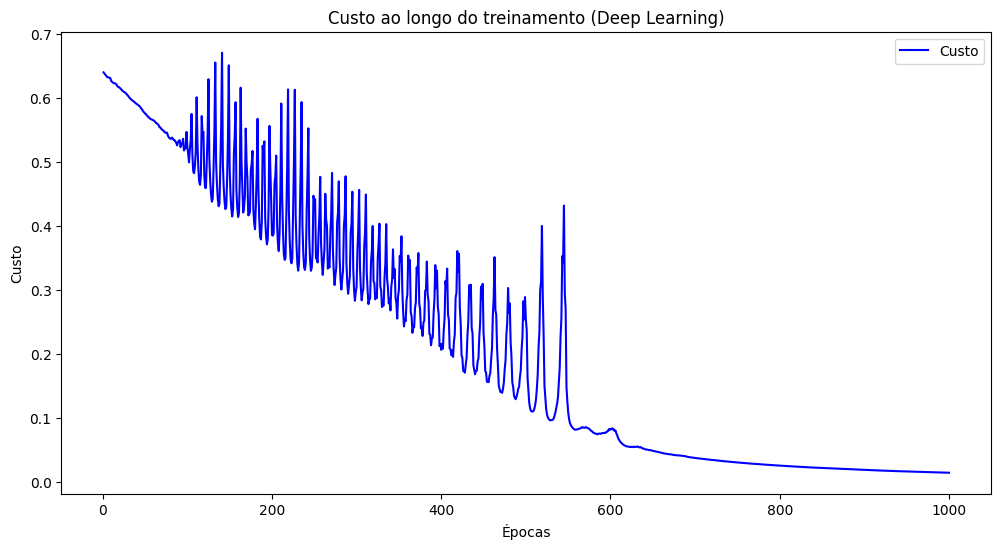

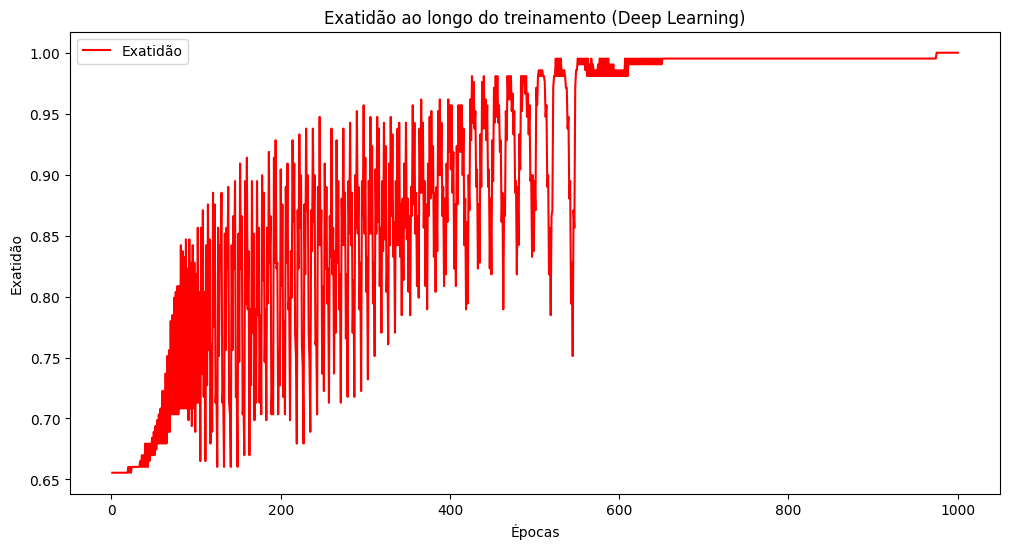

In [25]:
# PARA VOCÊ FAZER: visualização do resultado do treinamento da rede deep-learning

# Salva custo e exatidão em vetores
### COMECE AQUI ###

custodl = historydl.history['loss']
exatidaodl = historydl.history['accuracy']

### TERMINE AQUI ###

# Cria vetor de épocas
### COMECE AQUI ###

epocasdl = range(1, len(custodl) + 1)

### TERMINE AQUI ###

# Gráfico do custo em função das épocas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(epocasdl, custodl, 'b-', label='Custo')
plt.title('Custo ao longo do treinamento (Deep Learning)')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

### TERMINE AQUI ###

# Gráfico da exatidão em função das épocas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(epocasdl, exatidaodl, 'r-', label='Exatidão')
plt.title('Exatidão ao longo do treinamento (Deep Learning)')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

### TERMINE AQUI ###

### Exercício #13:

Na célula abaixo introduza os comandos para avaliar a sua rede deep-learning para os dados de treinamento e de teste.

In [26]:
# PARA VOCÊ FAZER: calculo do custo e exatidão para os dados de treinamento e de teste para a rede deep-learning

# Usando método evaluate calcule o custo e a exatidão dos dados de treinamento e depois apresente os resultados
### COMECE AQUI ###

custo_e_metricasdl_train = rnadl.evaluate(train_set_x, train_set_y, verbose=0)

### TERMINE AQUI ###
print(f"Custo e exatidão nos dados de treinamento (Deep Learning): {custo_e_metricasdl_train}")

# Usando método evaluate calcule o custo e a exatidão dos dados de teste e depois apresente os resultados
### COMECE AQUI ###

custo_e_metricasdl_test = rnadl.evaluate(test_set_x, test_set_y, verbose=0)

### TERMINE AQUI ###
print(f"Custo e exatidão nos dados de teste (Deep Learning): {custo_e_metricasdl_test}")

Custo e exatidão nos dados de treinamento (Deep Learning): [0.014121562242507935, 1.0]
Custo e exatidão nos dados de teste (Deep Learning): [0.9487287402153015, 0.7799999713897705]


**Saída esperada:**

    209/209 [==============================] - 0s 482us/sample - loss: 0.0115 - acc: 1.0000
    [0.011545336649320913, 1.0]
    50/50 [==============================] - 0s 399us/sample - loss: 1.0013 - acc: 0.7400
    [1.0013008093833924, 0.74]

### Exercício #14:

Na célula abaixo introduza os comandos para clcular as classes previstas para os dados de teste.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


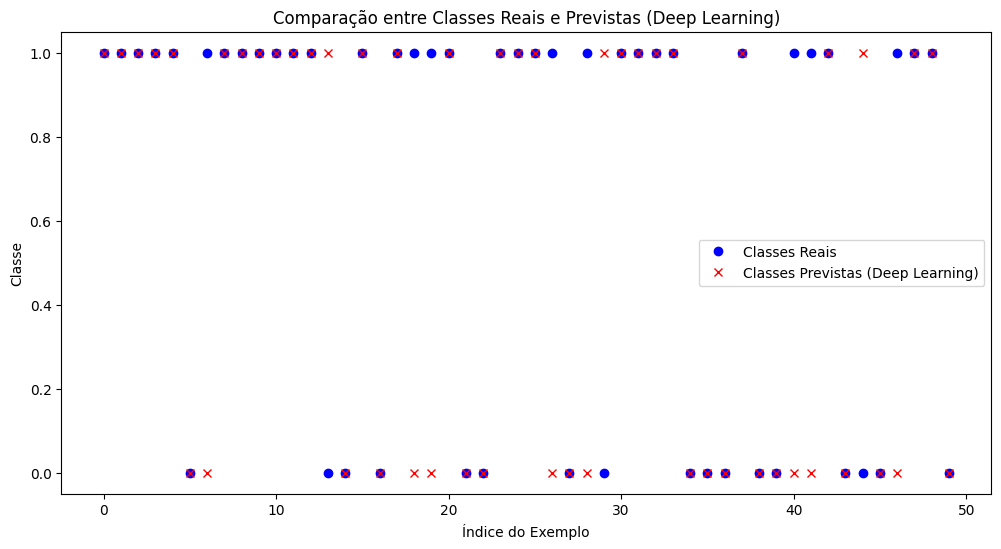

In [28]:
# PARA VOCÊ FAZER: calculo das classes previstas dos dados de teste para a rede deep-learning

# Usando método predict calcule as classes previstas
### COMECE AQUI ###

yy_prevdl = rnadl.predict(test_set_x)
yy_prevdl = np.round(yy_prevdl).astype(int)  # Transforma saída prevista em números inteiros

### TERMINE AQUI ###

# Gráfico das classes reais e previstas
### COMECE AQUI ###

plt.figure(figsize=(12, 6))
plt.plot(test_set_y, 'bo', label='Classes Reais')  # 'bo' para pontos azuis (blue dots)
plt.plot(yy_prevdl, 'rx', label='Classes Previstas (Deep Learning)')  # 'rx' para cruzes vermelhas (red crosses)
plt.title('Comparação entre Classes Reais e Previstas (Deep Learning)')
plt.xlabel('Índice do Exemplo')
plt.ylabel('Classe')
plt.legend()
plt.show()

### TERMINE AQUI ###

**Saída esperada:**

O número de erros de classificação é igual a 12 (ou 13), representado por 12 (13) bolinhas vermelhas, o que significa 76% (74%) dos 50 exemplos de teste.

**Interpretação dos resultados:**

Se você fez tudo correto, então, os resultados obtidos do custo e da exatidão para os dados de teste são melhores para a rede neural deep-learning do que para a rede neural rasa, como era de se esperar.

Observe que a rede deep learning possui quase o mesmo número de parâmetros do que a rede rasa, mas obtém resultados mais satisfatórios. 

O que fez com que os resultados da rede deep learning fossem muito melhores do que a rede rasa? O número de camadas, o tipo de função de ativação, ou simplesmenete o número de parâmetros?

<font color='blue'>
    
**O que é importante lembrar:**
- A escolha do número de neurônios das camadas da rede é muito importane
- O tipo de função de ativação usada pode fazer diferença nos resultados
- Não é uma tarefa fácil desenvolver uma rede neural que apresenta um desempenho bom, mas não é impossível

## 6 - Teste as redes que você desenvolveu com sua própria imagem (exercício opcional) ##

Você pode usar qualquer imagem e verificar se as suas redes neurais são eficientes. Para fazer isso faça:
    1. Clique em "File" na parte superior desse notebook e depois clique "Open" para ir para o seu diretório.
    2. Adicione a sua imagem nesse diretório.
    3. Troque o nome do arquivo onde se encontra a imagem no código abaixo.
    4. Execute o código e verifique se a rede acerta (1 = imagem mostra gato, 0 = imagem não tem gato)!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
y = 1, sua rede prevê "cat" picture.


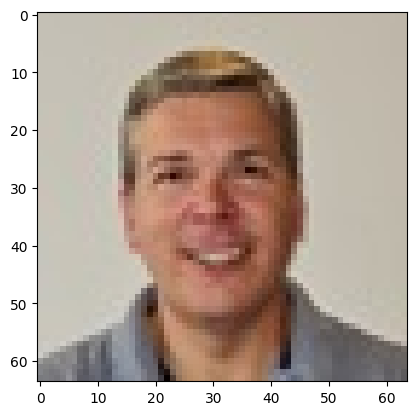

In [32]:
# PARA VOCÊ FAZER: teste da rede com suas imagens

# Coloque o nome do arquivo com a sua imagem
## COMECE AQUI ##
my_image = "my_image.jpg"  # Substitua pelo nome do seu arquivo
## TERMINE AQUI ##

# Pré-processamento da imagem para acertar dimensões.
fname = my_image
image = Image.open(fname)
my_image = image.resize((num_px, num_px), Image.Resampling.LANCZOS)
my_image = np.array(my_image)
my_image = my_image.reshape((1, num_px*num_px*3))
my_image = my_image.astype(float) / 255.0  # Normaliza a imagem

# Previsão da rede neural
y_prev_myimage = rnadl.predict(my_image)
my_predicted_image = np.round(y_prev_myimage)
my_predicted_image = my_predicted_image.astype(int)

# Mostra a imagem e a previsão
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", sua rede prevê \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Finalmente, como sugestão, tente fazer alterações de parâmetros e executar o notebook novamente. Mas lembre-se de salvar o seu trabalho em um arquivo pdf e enviar para avaliação antes de modificar o notebook e realizar os seus testes.

Algumas sugestões do que alterar:

- Número de camadas;
- Número de neurônios nas camadas;
- Funções de ativação;
- Tente impor um taxa de aprendizado;
- Tente outras formas de normalizar os dados.


In [ ]:
#TENTANDO MELHORAR A REDE NEURAL ATRAVES DE NOVAS ALTERAÇÕES

Custo e exatidão nos dados de treinamento (rnad2): [8.997192708193325e-06, 1.0]
Custo e exatidão nos dados de teste (rnad2): [1.936386227607727, 0.8999999761581421]


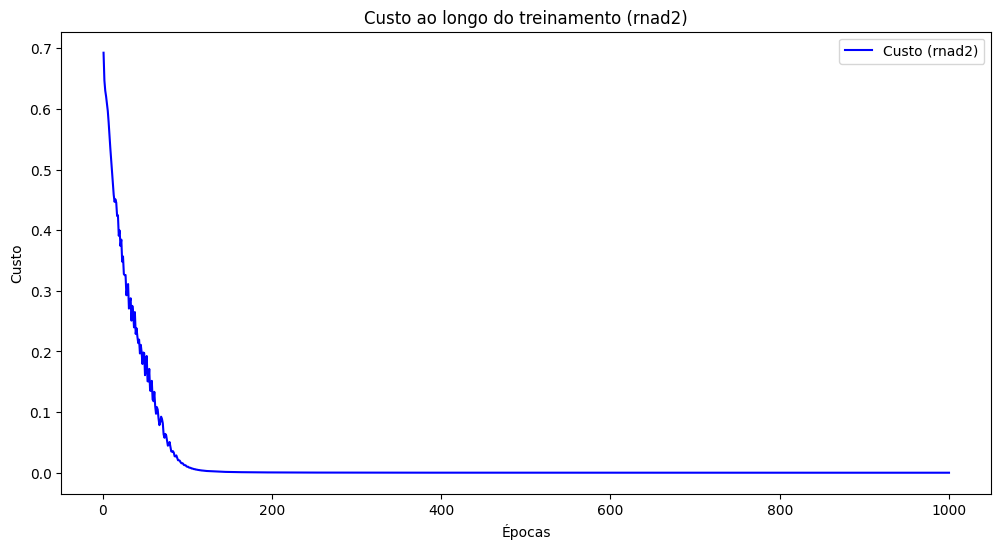

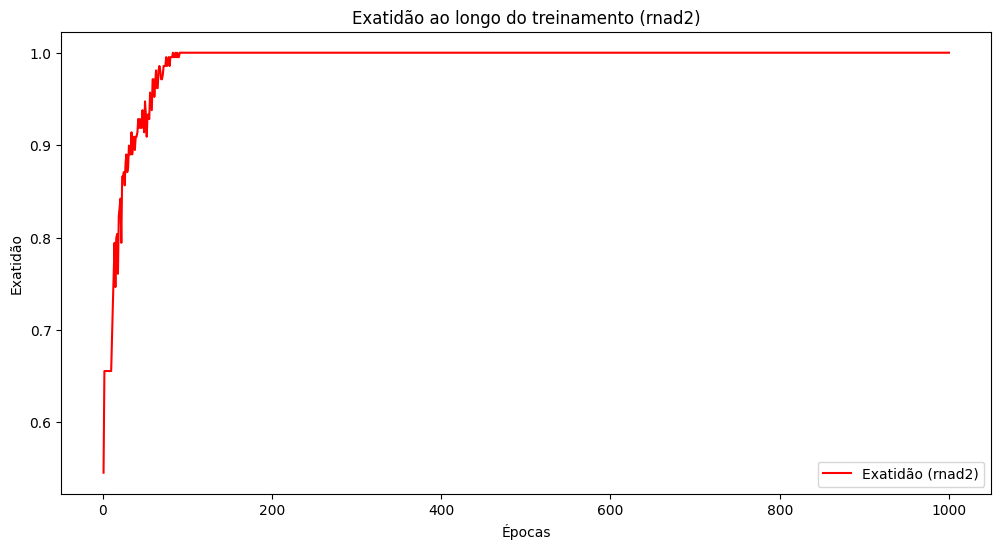

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


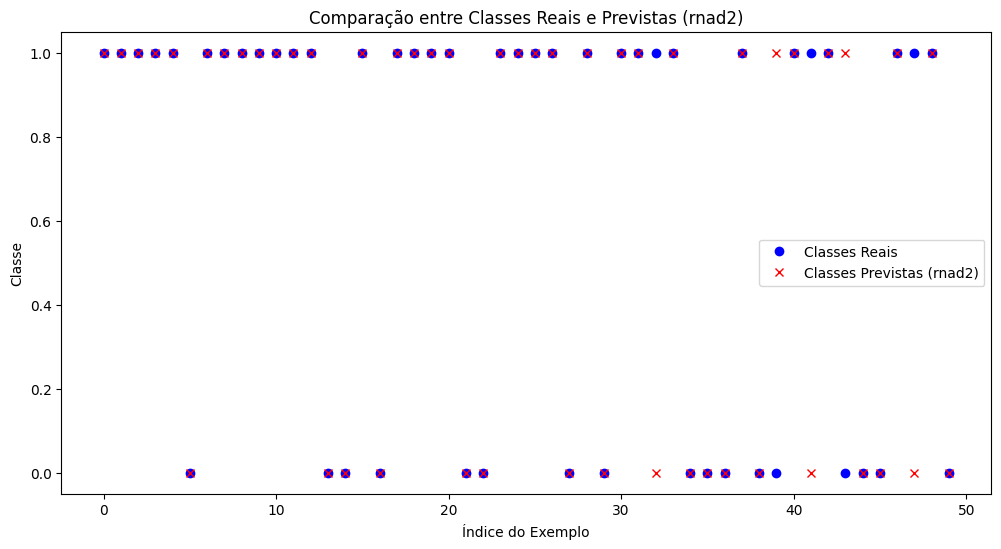

In [48]:
from tensorflow.keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Construção da rede rnad2
def build_rnad2(input_shape):
    model = models.Sequential()
    
    # Camadas Convolucionais
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Achata a saída para a camada densa
    model.add(layers.Flatten())
    
    # Camadas Densas
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Configuração da nova rede rnad2
input_shape = (num_px, num_px, 3)
rnad2 = build_rnad2(input_shape)

# Compilação da rede
rnad2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Ajuste: Verifica a forma correta do vetor de etiquetas (y)
train_set_y = train_set_y.reshape(-1, 1)  # Garante que y tenha a forma (209, 1)

# Treinamento da rede por 1000 épocas
historyd2 = rnad2.fit(train_set_x_orig / 255.0, train_set_y, epochs=1000, batch_size=209, verbose=0)

# Avaliação nos dados de treinamento
custo_e_metricasd2_train = rnad2.evaluate(train_set_x_orig / 255.0, train_set_y, verbose=0)
print(f"Custo e exatidão nos dados de treinamento (rnad2): {custo_e_metricasd2_train}")

# Avaliação nos dados de teste
custo_e_metricasd2_test = rnad2.evaluate(test_set_x_orig / 255.0, test_set_y.reshape(-1, 1), verbose=0)
print(f"Custo e exatidão nos dados de teste (rnad2): {custo_e_metricasd2_test}")

# Visualização dos resultados do treinamento
custod2 = historyd2.history['loss']
exatidaod2 = historyd2.history['accuracy']
epocasd2 = range(1, len(custod2) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocasd2, custod2, 'b-', label='Custo (rnad2)')
plt.title('Custo ao longo do treinamento (rnad2)')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epocasd2, exatidaod2, 'r-', label='Exatidão (rnad2)')
plt.title('Exatidão ao longo do treinamento (rnad2)')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

# Previsão das classes nos dados de teste
yy_prevdl2 = rnad2.predict(test_set_x_orig / 255.0)
yy_prevdl2 = np.round(yy_prevdl2).astype(int)  # Transforma saída prevista em números inteiros

# Gráfico das classes reais e previstas
plt.figure(figsize=(12, 6))
plt.plot(test_set_y.reshape(-1, 1), 'bo', label='Classes Reais')  # 'bo' para pontos azuis (blue dots)
plt.plot(yy_prevdl2, 'rx', label='Classes Previstas (rnad2)')  # 'rx' para cruzes vermelhas (red crosses)
plt.title('Comparação entre Classes Reais e Previstas (rnad2)')
plt.xlabel('Índice do Exemplo')
plt.ylabel('Classe')
plt.legend()
plt.show()

Número de erros de classificação: 5


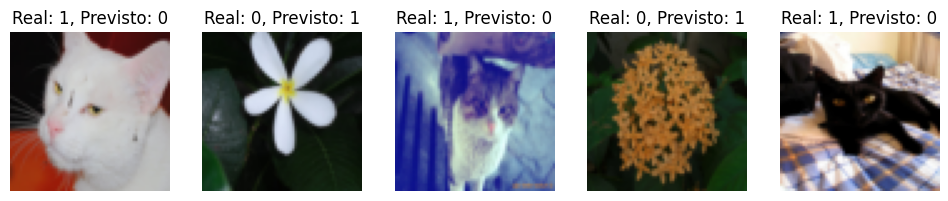

In [51]:
# Identifica os índices das previsões incorretas
indices_erro = np.where(yy_prevdl2 != test_set_y.reshape(-1, 1))[0]

print(f"Número de erros de classificação: {len(indices_erro)}")

# Visualiza as imagens previstas incorretamente
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices_erro):
    plt.subplot(5, 5, i + 1)  # Ajuste o tamanho da grade conforme necessário
    plt.imshow(test_set_x_orig[idx].astype(np.uint8))
    plt.title(f"Real: {test_set_y[0, idx]}, Previsto: {yy_prevdl2[idx][0]}")
    plt.axis('off')
plt.show()

Custo e exatidão nos dados de treinamento (rnad3): [0.0005036111688241363, 1.0]
Custo e exatidão nos dados de teste (rnad3): [2.010327100753784, 0.7200000286102295]


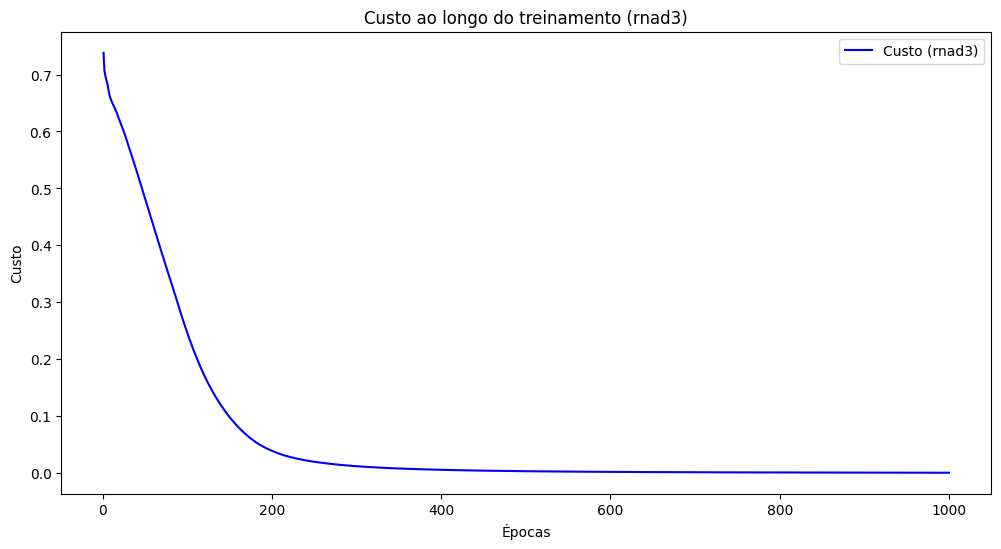

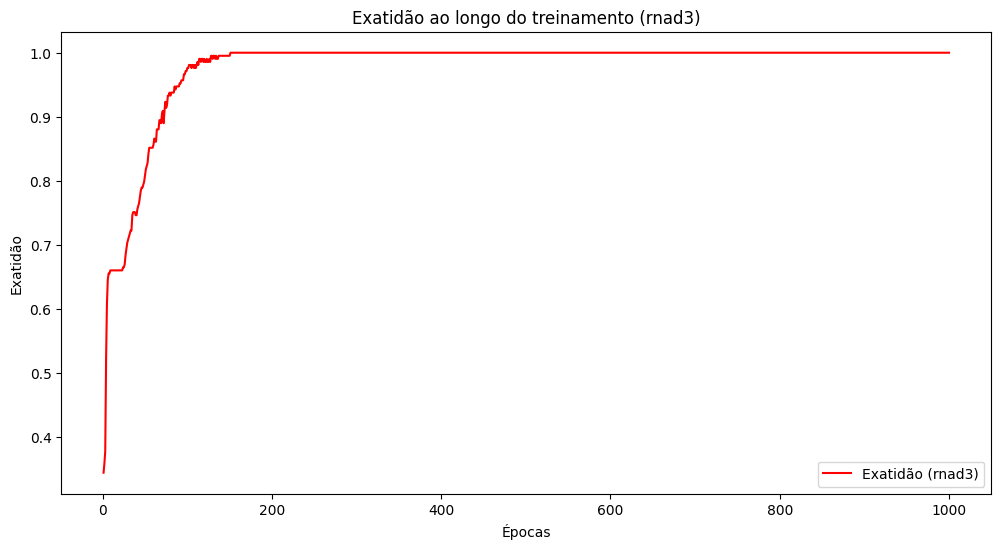

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


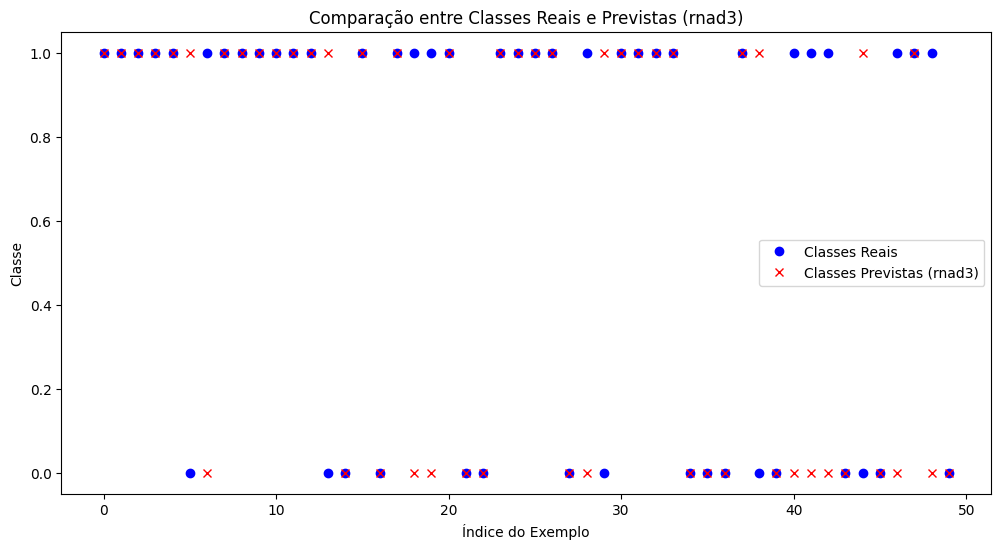

Número de erros de classificação: 14


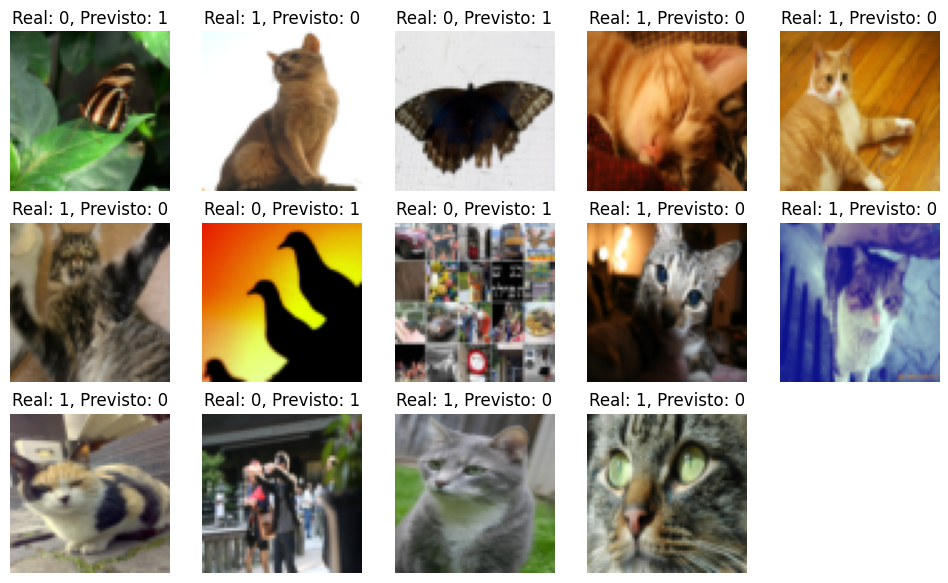

In [65]:
from tensorflow.keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# Construção da rede rnad3
def build_rnad3(input_shape):
    model = models.Sequential()
    
    # Camadas Ocultas
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))

    
    # Camada de Saída
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Configuração da nova rede rnad3
input_shape = (num_px * num_px * 3,)
rnad3 = build_rnad3(input_shape)

# Compilação da rede
rnad3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Ajuste: Verifica a forma correta do vetor de etiquetas (y)
train_set_x_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)

# Treinamento da rede por 1000 épocas
historyd3 = rnad3.fit(train_set_x_flat / 255.0, train_set_y, epochs=1000, batch_size=209, verbose=0)

# Avaliação nos dados de treinamento
custo_e_metricasd3_train = rnad3.evaluate(train_set_x_flat / 255.0, train_set_y, verbose=0)
print(f"Custo e exatidão nos dados de treinamento (rnad3): {custo_e_metricasd3_train}")

# Avaliação nos dados de teste
custo_e_metricasd3_test = rnad3.evaluate(test_set_x_flat / 255.0, test_set_y, verbose=0)
print(f"Custo e exatidão nos dados de teste (rnad3): {custo_e_metricasd3_test}")

# Visualização dos resultados do treinamento
custod3 = historyd3.history['loss']
exatidaod3 = historyd3.history['accuracy']
epocasd3 = range(1, len(custod3) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocasd3, custod3, 'b-', label='Custo (rnad3)')
plt.title('Custo ao longo do treinamento (rnad3)')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epocasd3, exatidaod3, 'r-', label='Exatidão (rnad3)')
plt.title('Exatidão ao longo do treinamento (rnad3)')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

# Previsão das classes nos dados de teste
yy_prevd3 = rnad3.predict(test_set_x_flat / 255.0)
yy_prevd3 = np.round(yy_prevd3).astype(int)  # Transforma saída prevista em números inteiros

# Gráfico das classes reais e previstas
plt.figure(figsize=(12, 6))
plt.plot(test_set_y, 'bo', label='Classes Reais')  # 'bo' para pontos azuis (blue dots)
plt.plot(yy_prevd3, 'rx', label='Classes Previstas (rnad3)')  # 'rx' para cruzes vermelhas (red crosses)
plt.title('Comparação entre Classes Reais e Previstas (rnad3)')
plt.xlabel('Índice do Exemplo')
plt.ylabel('Classe')
plt.legend()
plt.show()

# Identifica os índices das previsões incorretas
indices_erro = np.where(yy_prevd3 != test_set_y)[0]

print(f"Número de erros de classificação: {len(indices_erro)}")

# Visualiza as imagens previstas incorretamente
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices_erro):
    plt.subplot(5, 5, i + 1)  # Ajuste o tamanho da grade conforme necessário
    plt.imshow(test_set_x_orig[idx].astype(np.uint8))
    plt.title(f"Real: {test_set_y[idx][0]}, Previsto: {yy_prevd3[idx][0]}")
    plt.axis('off')
plt.show()

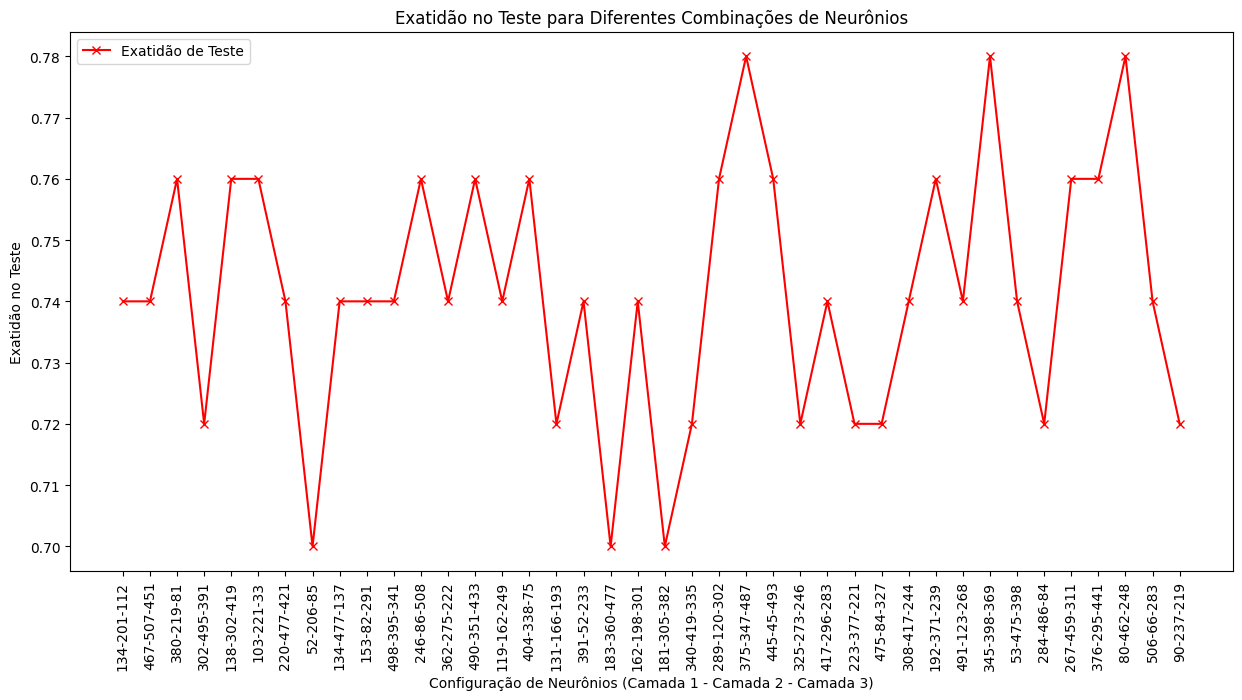

In [69]:
import numpy as np
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt

# Função para construir a rede neural com 3 camadas ocultas
def build_rnad3(input_shape, n1, n2, n3):
    model = models.Sequential()
    model.add(layers.Dense(n1, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(n2, activation='relu'))
    model.add(layers.Dense(n3, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Gerar 40 combinações de neurônios aleatoriamente
np.random.seed(42)  # Para reprodutibilidade
neuronios_camada_1 = np.random.randint(32, 512, 40)
neuronios_camada_2 = np.random.randint(32, 512, 40)
neuronios_camada_3 = np.random.randint(32, 512, 40)

combinacoes = list(zip(neuronios_camada_1, neuronios_camada_2, neuronios_camada_3))

# Variáveis para armazenar os resultados
resultados_teste = []
configuracoes = []

# Ajuste dos dados
train_set_x_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1) / 255.0
test_set_x_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1) / 255.0
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)
input_shape = (train_set_x_flat.shape[1],)

# Loop para testar as 40 combinações de neurônios
for n1, n2, n3 in combinacoes:
    rnad3 = build_rnad3(input_shape, n1, n2, n3)
    rnad3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Treinamento da rede
    rnad3.fit(train_set_x_flat, train_set_y, epochs=500, batch_size=209, verbose=0)
    
    # Avaliação nos dados de teste
    custo_e_metricasd3_test = rnad3.evaluate(test_set_x_flat, test_set_y, verbose=0)
    
    # Armazenar os resultados
    resultados_teste.append(custo_e_metricasd3_test[1])  # Exatidão de teste
    configuracoes.append(f"{n1}-{n2}-{n3}")

# Plotar os resultados de exatidão no teste
plt.figure(figsize=(15, 7))
plt.plot(configuracoes, resultados_teste, 'rx-', label='Exatidão de Teste')
plt.title('Exatidão no Teste para Diferentes Combinações de Neurônios')
plt.xlabel('Configuração de Neurônios (Camada 1 - Camada 2 - Camada 3)')
plt.ylabel('Exatidão no Teste')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# Construção da rede rnad3
def build_rnad3(input_shape):
    model = models.Sequential()
    
    # Camadas Ocultas
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))

    
    # Camada de Saída
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Configuração da nova rede rnad3
input_shape = (num_px * num_px * 3,)
rnad3 = build_rnad3(input_shape)

# Compilação da rede
rnad3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Ajuste: Verifica a forma correta do vetor de etiquetas (y)
train_set_x_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
train_set_y = train_set_y.reshape(-1, 1)
test_set_y = test_set_y.reshape(-1, 1)

# Treinamento da rede por 1000 épocas
historyd3 = rnad3.fit(train_set_x_flat / 255.0, train_set_y, epochs=1000, batch_size=209, verbose=0)

# Avaliação nos dados de treinamento
custo_e_metricasd3_train = rnad3.evaluate(train_set_x_flat / 255.0, train_set_y, verbose=0)
print(f"Custo e exatidão nos dados de treinamento (rnad3): {custo_e_metricasd3_train}")

# Avaliação nos dados de teste
custo_e_metricasd3_test = rnad3.evaluate(test_set_x_flat / 255.0, test_set_y, verbose=0)
print(f"Custo e exatidão nos dados de teste (rnad3): {custo_e_metricasd3_test}")

# Visualização dos resultados do treinamento
custod3 = historyd3.history['loss']
exatidaod3 = historyd3.history['accuracy']
epocasd3 = range(1, len(custod3) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocasd3, custod3, 'b-', label='Custo (rnad3)')
plt.title('Custo ao longo do treinamento (rnad3)')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epocasd3, exatidaod3, 'r-', label='Exatidão (rnad3)')
plt.title('Exatidão ao longo do treinamento (rnad3)')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

# Previsão das classes nos dados de teste
yy_prevd3 = rnad3.predict(test_set_x_flat / 255.0)
yy_prevd3 = np.round(yy_prevd3).astype(int)  # Transforma saída prevista em números inteiros

# Gráfico das classes reais e previstas
plt.figure(figsize=(12, 6))
plt.plot(test_set_y, 'bo', label='Classes Reais')  # 'bo' para pontos azuis (blue dots)
plt.plot(yy_prevd3, 'rx', label='Classes Previstas (rnad3)')  # 'rx' para cruzes vermelhas (red crosses)
plt.title('Comparação entre Classes Reais e Previstas (rnad3)')
plt.xlabel('Índice do Exemplo')
plt.ylabel('Classe')
plt.legend()
plt.show()

# Identifica os índices das previsões incorretas
indices_erro = np.where(yy_prevd3 != test_set_y)[0]

print(f"Número de erros de classificação: {len(indices_erro)}")

# Visualiza as imagens previstas incorretamente
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices_erro):
    plt.subplot(5, 5, i + 1)  # Ajuste o tamanho da grade conforme necessário
    plt.imshow(test_set_x_orig[idx].astype(np.uint8))
    plt.title(f"Real: {test_set_y[idx][0]}, Previsto: {yy_prevd3[idx][0]}")
    plt.axis('off')
plt.show()